# GRU⻔控循环单元

我们可能会遇到这样的情况:

早期观测值对预测所有未来观测值具有非常重要的意义。

考虑一个极端 情况，其中第一个观测值包含一个校验和，目标是在序列的末尾辨别校验和是否正确。

在这种情况下， 第一个词元的影响至关重要。我们希望有某些机制能够在一个记忆元里存储重要的早期信息。如果没 有这样的机制，我们将不得不给这个观测值指定一个非常大的梯度，因为它会影响所有后续的观测值。

• 我们可能会遇到这样的情况:一些词元没有相关的观测值。例如，在对网⻚内容进行情感分析时，可能 有一些辅助HTML代码与网⻚传达的情绪无关。我们希望有一些机制来跳过隐状态表示中的此类词元。


• 我们可能会遇到这样的情况:序列的各个部分之间存在逻辑中断。例如，书的章节之间可能会有过渡存 在，或者证券的熊市和牛市之间可能会有过渡存在。在这种情况下，最好有一种方法来重置我们的内部 状态表示。

## 门

- 更新门(update gate)

能关注的机制


- 遗忘门(reset gate)

能遗忘的机制

![title](attachment/gru.png)

$$
R_t = \sigma(X_tW_{xr} + H_{t-1}W_{hr} + b_r)\\
Z_t = \sigma(X_tW_{xz} + H_{t-1}W_{hz} + b_z)
$$

- 候选隐状态
![title](attachment/gru2.png)
$$
\widetilde H_t = tanh(X_tW_{xr} + (R_t\odot H_{t-1})W_{hr} + b_r)
$$

- 隐状态

$$
H_t = Z_t\odot H_{t-1} + (1-Z_t)\odot {\widetilde H}_{t}
$$

ps：

pip install d2l

pip install matplotlib==3.0.0

In [1]:
import os
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l
import matplotlib.pyplot as plt
import collections
import re
import numpy as np

## Artifical GRU


In [2]:
def get_params(vocab_size, num_hiddens, device):
  def three():
    return (
        torch.randn((vocab_size, num_hiddens), device=device)*0.001,
        torch.randn((num_hiddens, num_hiddens), device=device)*0.001,
        torch.zeros(num_hiddens, device=device)
    )

  W_xz, W_hz, b_z = three() # update
  W_xr, W_hr, b_r = three() # reset
  W_xh, W_hh, b_h = three() # 候选隐状态

  # output w，b
  W_hq = torch.randn((num_hiddens, vocab_size), device=device)*0.001
  b_q = torch.zeros(vocab_size, device=device)

  params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
  
  for i in params:
    i.requires_grad_(True)

  return params
  

In [3]:
def init_gru_state(batch_size, num_hiddens, device):
  return (torch.zeros((batch_size, num_hiddens), device=device), )

In [4]:
def gru(inputs, state, params):
  W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
  H, = state
  outputs = []

  for X in inputs:
    Z = torch.sigmoid(X@W_xz + H@W_hz + b_z)
    R = torch.sigmoid(X@W_xr + H@W_hr + b_r)
    H_hidden_state = torch.tanh(X@W_xh + (R*H)@W_hh + b_h)
    H = Z*H + (1-Z)*H_hidden_state
    Y = H@W_hq + b_q
    outputs.append(Y)
  return torch.cat(outputs, dim=0), (H,)

## Train

In [5]:
# 1.load_dataset
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [6]:
# 2. Structure RNN
num_hiddens = 256
state = torch.zeros(batch_size, num_hiddens)


class RNNModel:
  '''循环神经网络'''
  def __init__(self, forward_fn, init_state, batch_size, 
               vocab_size, num_hidden, params, 
               device=torch.device('cuda')):
    self.device = device
    self.vocab_size = vocab_size
    self.forward_fn = forward_fn
    self.params = get_params(vocab_size, num_hiddens, device)
    self.init_state = init_state
    self.batch_size = batch_size
    self.num_hidden = num_hidden

  def __call__(self, X, state):
    X = F.one_hot(X.T.long(), self.vocab_size).type(torch.float32)
    return self.forward_fn(X, state, self.params)

  def begin_state(self, batch_size):
    return self.init_state(batch_size, self.num_hidden, self.device)

net = RNNModel(forward_fn=gru, init_state=init_gru_state, 
               batch_size=batch_size, num_hidden=256, 
               params=get_params, vocab_size=len(vocab))

In [7]:
state = net.begin_state(batch_size)
X = torch.rand(32,35).cuda()
y, state = net(X, state)
y.shape, state[0].shape

(torch.Size([1120, 28]), torch.Size([32, 256]))

In [8]:
# 3. loss
loss = nn.CrossEntropyLoss()

# 4. optimizer
opt = torch.optim.SGD(net.params, lr=1)

In [9]:
# 5. Train
%%time
def predict(prefix, num_preds, net, vocab, state, device=torch.device('cuda')):
  def get_word_order_tensor(word, vocab, device):
    return torch.LongTensor([vocab[word]]).reshape(1,1).to(device)

  state = net.begin_state(device)
  output = []

  net.to(device)
  for y in prefix:
    word_num = get_word_order_tensor(y, vocab, device)
    _, state = net(word_num, state)
    output.append(word_num)

  for p in range(num_preds):
    y, state = net(get_word_order_tensor(output[-1], vocab, device), state)
    output.append(torch.argmax(y, axis=1))
  
  return ''.join([vocab.idx_to_token[i] for i in output])

def grad_clipping(net, theta):
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad]
  else:
    params = net.params
  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
  if norm > theta:
    for param in params:
      param.grad[:] *= theta / norm

state = None
epochs = 500
perplexity = []
for epoch in range(epochs):
  epoch_loss = []
  for X, Y in train_iter:
    y = Y.T.reshape(-1)
    X, y = X.cuda(), y.cuda()
    state = net.begin_state(batch_size=X.shape[0])
    y_hat, state = net(X, state)
    # state 是叶子节点，不可以直接设置grad
    state = (state[0].detach(),)
    l = loss(y_hat, y.long()).mean()
    epoch_loss.append(l.item())
    
    opt.zero_grad()
    l.backward()
    grad_clipping(net,1)
    opt.step()
  
  epoch_perplexity = np.exp(np.mean(epoch_loss))
  if (epoch+1)%50==0:
    print(f'epoch: {epoch+1}, perplexity:{epoch_perplexity:f}')
  perplexity.append(epoch_perplexity)

epoch: 50, perplexity:12.703597
epoch: 100, perplexity:10.017522
epoch: 150, perplexity:8.504002
epoch: 200, perplexity:7.453061
epoch: 250, perplexity:6.491690
epoch: 300, perplexity:5.408006
epoch: 350, perplexity:4.255309
epoch: 400, perplexity:3.193586
epoch: 450, perplexity:2.301708
epoch: 500, perplexity:1.828007
CPU times: user 2min 9s, sys: 433 ms, total: 2min 10s
Wall time: 2min 15s


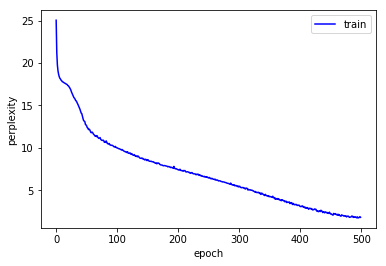

In [10]:
plt.plot(perplexity, label='train', color='b', linestyle='solid')
plt.xlabel('epoch')
plt.ylabel('perplexity')
plt.legend()
plt.show()

In [11]:
def predict_ch8(prefix, num_preds, net, vocab, device): 
  """在prefix后面生成新字符"""
  state = net.begin_state(batch_size=1) 
  outputs = [vocab[prefix[0]]]
  get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1)) 
  for y in prefix[1:]: # 预热期
    _, state = net(get_input(), state)
    outputs.append(vocab[y])
  for _ in range(num_preds): # 预测num_preds步
    y, state = net(get_input(), state)
    outputs.append(int(y.argmax(dim=1).reshape(1))) 
  return ''.join([vocab.idx_to_token[i] for i in outputs])

In [12]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller to be abou'

## Torch code

In [13]:
class RNNModel(nn.Module):
  '''循环神经网络'''
  def __init__(self, rnn_layer, vocab_size, **kwargs):
    super().__init__(**kwargs)
    self.rnn = rnn_layer
    self.vocab_size = vocab_size
    self.num_hiddens = self.rnn.hidden_size
    # 如果RNN是双向的(之后将介绍)，num_directions应该是2，否则应该是1
    if not self.rnn.bidirectional:
      self.num_directions = 1
      self.linear = nn.Linear(self.num_hiddens, self.vocab_size) 
    else:
      self.num_directions = 2
      self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
  
  def forward(self, inputs, state):
    X = F.one_hot(inputs.T.long(), self.vocab_size)
    X = X.to(torch.float32)
    Y, state = self.rnn(X, state)
    # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数) 
    # 它的输出形状是(时间步数*批量大小,词表大小)。
    output = self.linear(Y.reshape((-1, Y.shape[-1]))) 
    return output, state

  def begin_state(self, device, batch_size=1): 
    if not isinstance(self.rnn, nn.LSTM):
      # nn.GRU以张量作为隐状态
      return torch.zeros((self.num_directions * self.rnn.num_layers,
                             batch_size, self.num_hiddens),
                            device=device)
    else:
    # nn.LSTM以元组作为隐状态 
      return (torch.zeros((self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                    batch_size, self.num_hiddens), device=device))


In [14]:
def predict(prefix, num_preds, net, vocab, device=torch.device('cuda')):
  def get_word_order_tensor(sign, device):
    return torch.LongTensor([sign]).reshape(1,1).to(device)

  state = net.begin_state(batch_size=1, device=device)
  output = []

  net.to(device)
  for y in prefix[:-1]:
    word_num = get_word_order_tensor(vocab[y], device)
    _, state = net(word_num, state)
    output.append(int(word_num))
  word_num = get_word_order_tensor(vocab[prefix[-1]], device)
  output.append(word_num)

  for _ in range(num_preds):
    word_num = get_word_order_tensor(output[-1], device)
    y, state = net(word_num, state)
    output.append(int(torch.argmax(y, axis=1).reshape(1)))
  return ''.join([vocab.idx_to_token[i] for i in output])

def train_rnn(net, epochs, train_iter, loss, optim, 
              state=None, grad_clip_theta=1, device=torch.device('cuda')):
  # 梯度裁剪
  def grad_clipping(net, theta=grad_clip_theta):
    if isinstance(net, nn.Module):
      params = [p for p in net.parameters() if p.requires_grad]
    else:
      params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
      for param in params:
        param.grad[:] *= theta / norm

  loss = loss
  opt = optim
  state = state
  epochs = epochs
  perplexity = []

  net.to(device=device)
  for epoch in range(epochs):
    epoch_loss = []
    for X, Y in train_iter:
      y = Y.T.reshape(-1)
      X, y = X.to(device), y.to(device)
      state = net.begin_state(batch_size=X.shape[0], device=device)
      y_hat, state = net(X, state)
      # state 是叶子节点，不可以直接设置grad
      state = (state[0].detach(),)
      l = loss(y_hat, y.long()).mean()
      epoch_loss.append(l.item())
      
      opt.zero_grad()
      l.backward()
      grad_clipping(net)
      opt.step()
    epoch_perplexity = np.exp(np.mean(epoch_loss))
    if (epoch+1)%50==0:
      print(f'epoch: {epoch+1}, perplexity:{epoch_perplexity:f}')
    perplexity.append(epoch_perplexity)

  plt.plot(perplexity, label='train', color='b', linestyle='solid')
  plt.xlabel('epoch')
  plt.ylabel('perplexity')
  plt.legend()
  plt.show()

In [15]:
num_inputs = len(vocab)
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))

epoch: 50, perplexity:9.570560
epoch: 100, perplexity:7.858408
epoch: 150, perplexity:6.345326
epoch: 200, perplexity:4.518107
epoch: 250, perplexity:2.697252
epoch: 300, perplexity:1.745538
epoch: 350, perplexity:1.412773
epoch: 400, perplexity:1.429291
epoch: 450, perplexity:1.419175
epoch: 500, perplexity:1.360161


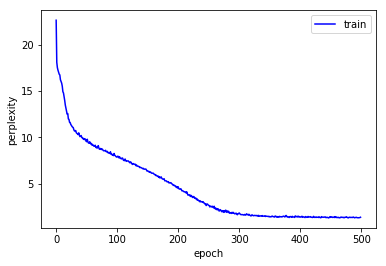

CPU times: user 11.5 s, sys: 382 ms, total: 11.9 s
Wall time: 11.7 s


In [16]:
%%time
loss = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=1)
train_rnn(model, epochs=500, train_iter=train_iter, loss=loss, optim=opt)

In [18]:
print(predict('time machine ', 20, model, vocab))

time machine by h g wellsithe tim
